# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IMPORTS

In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow
import glob
import matplotlib.pyplot as plt
import numpy as np

# Display Image utility function

In [ ]:
def display(images):
  fig = plt.figure(figsize=(10, 11))
  r,c,count=4,3,1
  for i in range(len(images)):
    for j in range(len(images[i])):
      fig.add_subplot(r,c,count,title=order[i])
      plt.imshow(cv2.cvtColor(images[i][j], cv2.COLOR_BGR2RGB))
      plt.axis('off')
      count+=1

# Set Folder path & Read Images.

In [ ]:
folder =  "/content/drive/MyDrive/KJSCE/LY/DL/ProjectData/SAMPLE/"
os.chdir(folder)

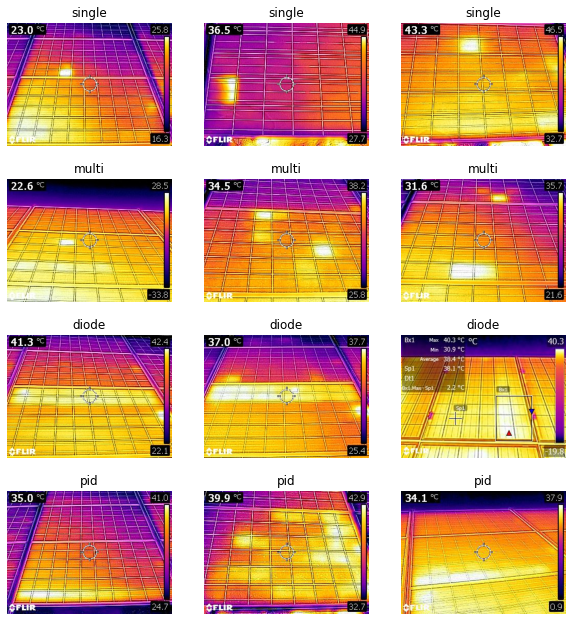

In [ ]:
order = {0:'single',1:'multi',2:'diode',3:'pid'}
images = []
for o in order.values():
  temp=[]
  for path in glob.glob(folder+o+'*'):
    # print(path)
    img = cv2.imread(path)
    temp.append(img)
  images.append(temp)
display(images)

# Trying different colour spaces

## RGB (Current)

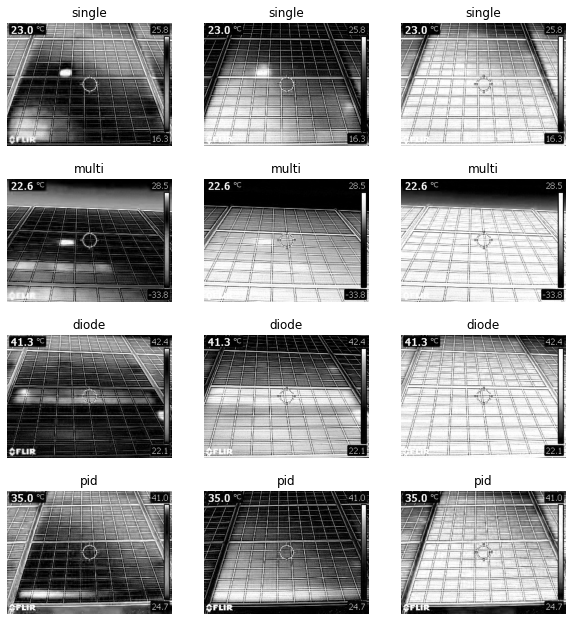

In [ ]:
single_images = [cat[0] for cat in images] # sample one image from each category to visualise.
split_images = [list(cv2.split(img)) for img in single_images] #split into B,G,R channels.
display(split_images)

## HSV

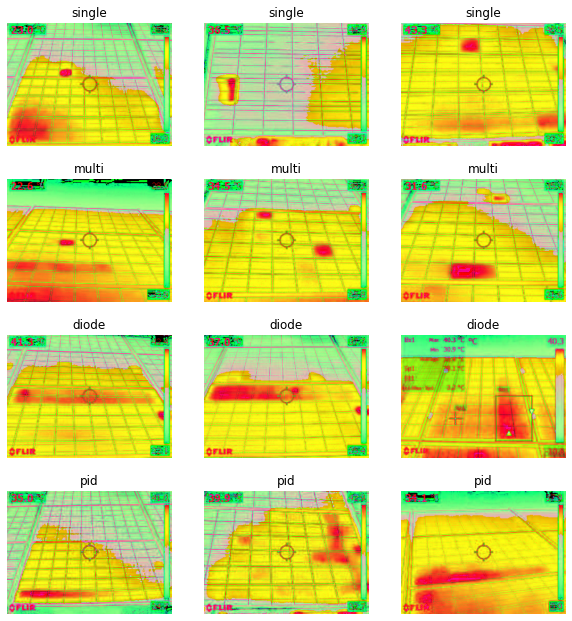

In [ ]:
hsv_images = [[cv2.cvtColor(img, cv2.COLOR_BGR2HSV) for img in cat_images] for cat_images in images]
display(hsv_images)

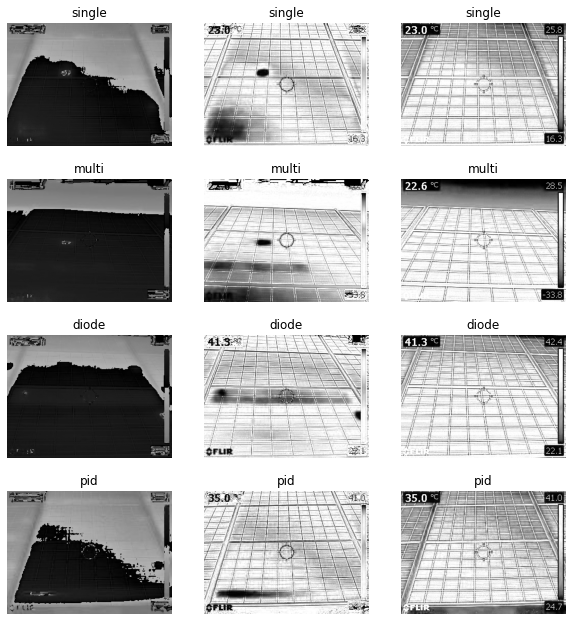

In [ ]:
single_images = [cat[0] for cat in hsv_images] # sample one image from each category to visualise.
split_images = [list(cv2.split(img)) for img in single_images] #split into H,S,V channels.
saturation_images = [x[1] for x in split_images]
display(split_images)

## Further Processing on HSV Images to identify and mark hotspots (Specifically Saturation Layer of HSV)

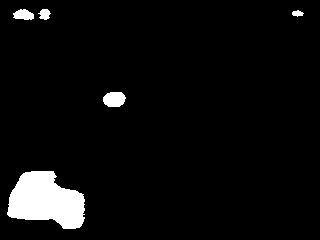

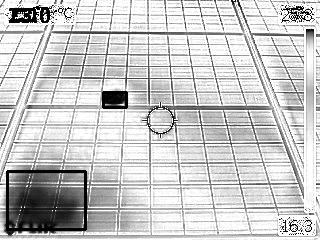

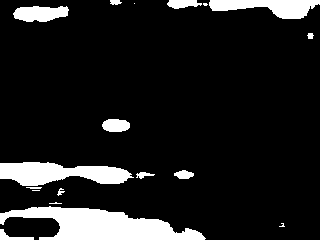

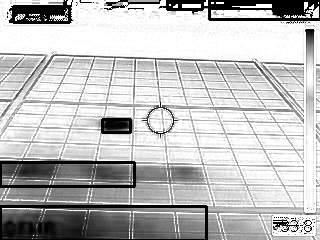

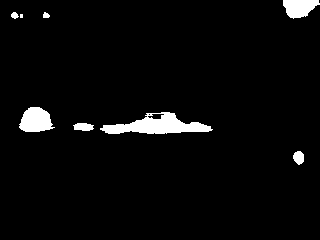

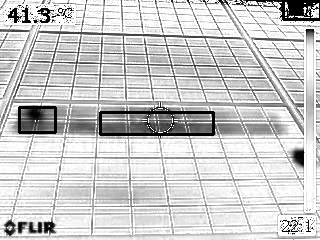

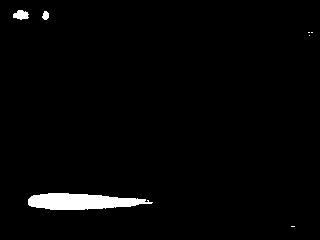

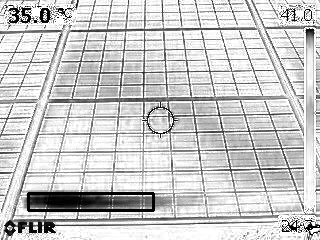

In [ ]:
for saturation_image in saturation_images:
    img=saturation_image.copy()
    cv2.rectangle(img, (4, 220) ,(57, 235), (255, 255, 255), -1)
    image=cv2.blur(img,(12,12))
    ret,thresh1 = cv2.threshold(image,127,255,cv2.THRESH_BINARY_INV)

    result = image.copy()
    cv2_imshow(thresh1)

    contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours=[cnt for cnt in contours if cv2.contourArea(cnt)>120]

    result=saturation_image.copy()
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        cv2.rectangle(result, (x, y), (x+w, y+h), (0,255,0),2)
    cv2_imshow(result)

### Processing of HSV Image directly , without split , but using the difference in colour for segmentation

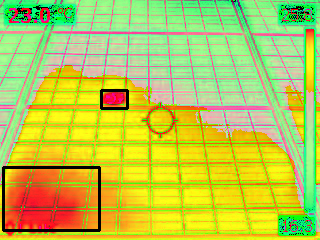

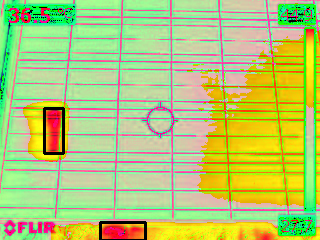

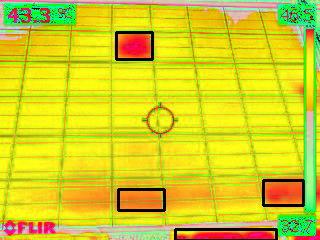

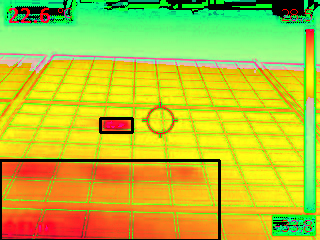

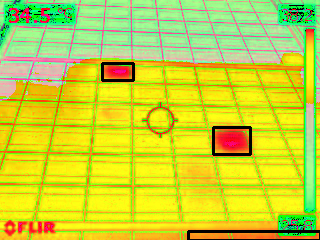

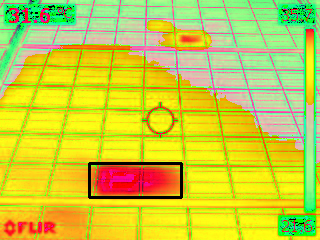

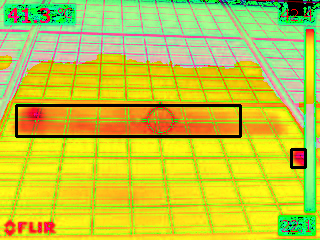

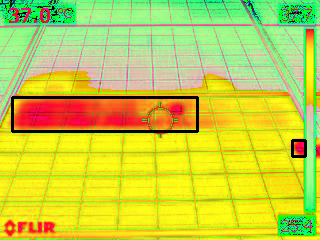

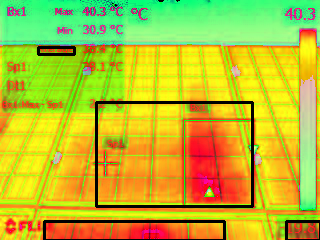

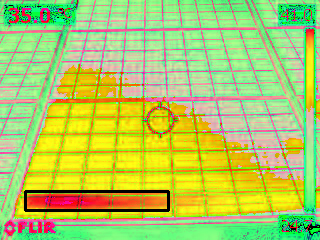

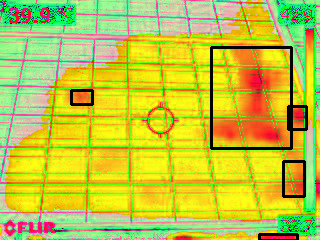

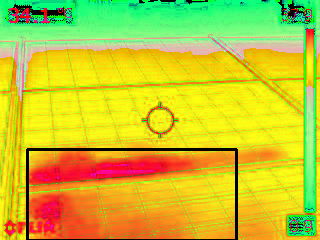

(240, 320, 3)


In [ ]:
for i in range(len(hsv_images)):
  for j in range(len(hsv_images[i])):
    img=hsv_images[i][j].copy()
    cv2.rectangle(img, (4, 220) ,(57, 235), (255, 255, 255), -1)
    image=cv2.blur(img,(9,9))
    result = image.copy()
    lower = np.array([0,0,155])
    upper = np.array([179,150,255])
    mask = cv2.inRange(image, lower, upper)
    # cv2_imshow( mask)

    contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours=[cnt for cnt in contours if cv2.contourArea(cnt)>120]

    result=hsv_images[i][j].copy()
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        cv2.rectangle(result, (x, y), (x+w, y+h), (0,0,0), 2)
    cv2_imshow(result)

# Image Augmentation

### Our entire dataset has a total of 1088 images
* diode : 100 + (60(horizontal) + 60(vertical) + 60(horizontal,vertical)) = 280
* dust : 39 + (39(horizontal) + 39(vertical) + 39(horizontal,vertical) = 156
* multicell : 199 + (50(horizontal) + 50(vertical)) = 299
* PID : 250 + (50(horizontal) + 50(vertical)) = 350
* single : 500 + (No augmentation) = 500

We can observe data is heavily unbalanced, which can have major impact on the model performance. Here we perform augmentation for 2 main reasons


*   Balance the dataset.
*   Increase the dataset size

Data Augmentation would be a necessary step to improve the model perfomance.



## FLIP LEFT-RIGHT (Horizontal Flip)

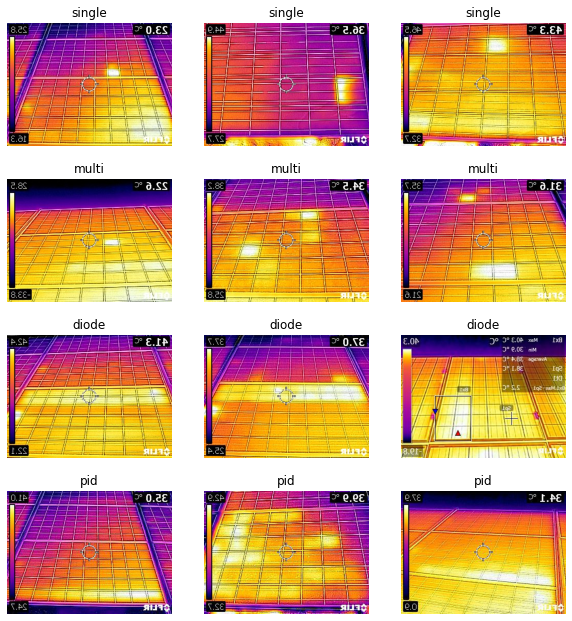

In [ ]:
flipped_images = []
for img_set in images:
  temp=[]
  for img in img_set:
    temp.append(cv2.flip(img,1))
  flipped_images.append(temp)
display(flipped_images)


## Vertical Flip


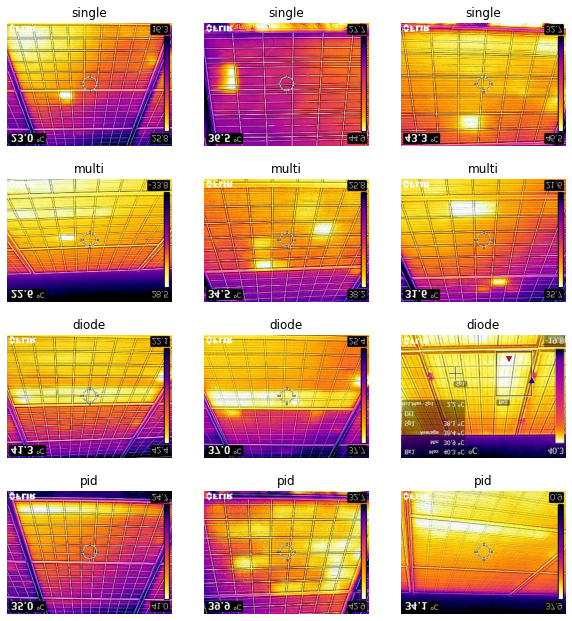

In [ ]:
flipped_images = []
for img_set in images:
  temp=[]
  for img in img_set:
    temp.append(cv2.flip(img,0))
  flipped_images.append(temp)
display(flipped_images)

## Noise injection

In [ ]:
def add_noise(img):
  gauss_noise=np.zeros((240,320),dtype=np.uint8)
  cv2.randn(gauss_noise,100,40)
  gauss_noise=(gauss_noise*0.5).astype(np.uint8)
  gn_img_b=cv2.add(img[:,:,0],gauss_noise)
  gn_img_g=cv2.add(img[:,:,1],gauss_noise)
  gn_img_r=cv2.add(img[:,:,2],gauss_noise)
  gn_img=cv2.merge([gn_img_b, gn_img_g, gn_img_r])
  return gn_img

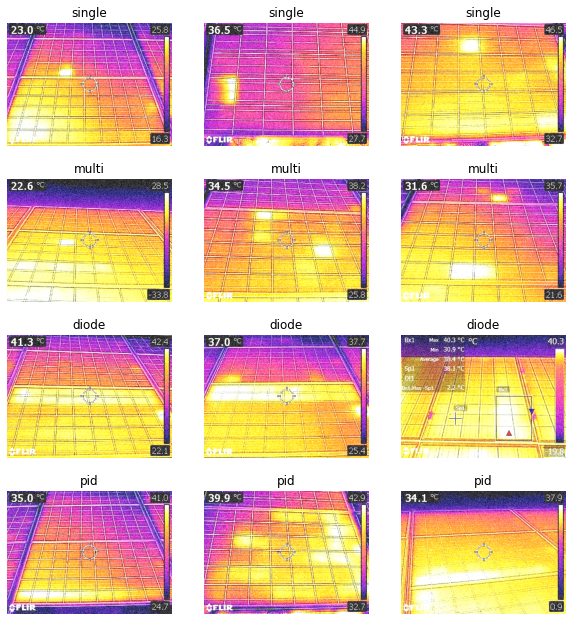

In [ ]:
noise_images = []
for img_set in images:
  temp=[]
  for img in img_set:
    temp.append(add_noise(img))
  noise_images.append(temp)
display(noise_images)